In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from skimage.feature import hog
import multiprocess as mp
import tensorflow as tf
from sklearn.cluster import KMeans

X_STRIPES = 10
Y_STRIPES = 10

In [2]:
imgs1 = np.random.randint(low=0,high=60,size=(300,300,3,67))
imgs2 = np.random.randint(low=100,high=160,size=(300,300,3,67))
imgs3 = np.random.randint(low=200,high=255,size=(300,300,3,67))
imgs=np.append(imgs1,imgs2,3)
imgs=np.append(imgs,imgs3,3)
imgs.shape

(300, 300, 3, 201)

In [3]:
new_data = []
for instance in range(imgs.shape[3]):
  img = imgs[:,:,:,instance]
  rows = np.vsplit(img,X_STRIPES)
  for row in rows:
    quadrants = np.hsplit(row,Y_STRIPES)
    for quadrant in quadrants:
      new_data.append(quadrant)
new_data = np.array(new_data)
new_data.shape

(20100, 30, 30, 3)

In [4]:
'''index_to_label = {0:"person",1:"animal",2:"nothing",3:"noise"}
label_to_index = {"person":0,"animal":1,"nothing":2,"noise":3}
labels = np.zeros((new_data.shape[0],))
plt.figure()
for instance in range(new_data.shape[0]):
  img = new_data[instance,:,:,:]
  plt.imshow(img)
  plt.show()
  labels[instance]= int(input()='''

'index_to_label = {0:"person",1:"animal",2:"nothing",3:"noise"}\nlabel_to_index = {"person":0,"animal":1,"nothing":2,"noise":3}\nlabels = np.zeros((new_data.shape[0],))\nplt.figure()\nfor instance in range(new_data.shape[0]):\n  img = new_data[instance,:,:,:]\n  plt.imshow(img)\n  plt.show()\n  labels[instance]= int(input()='

In [5]:
label_0= [0 for _ in range(imgs1.shape[3])]
label_1= [1 for _ in range(imgs2.shape[3])]
label_2= [2 for _ in range(imgs3.shape[3])]
labels = []
labels.extend(label_0)
labels.extend(label_1)
labels.extend(label_2)
labels = np.array(labels)
labels.shape

(201,)

In [6]:
# features
features = []
for instance in range(imgs.shape[3]):
  features_per_image = []
  imgR= new_data[instance,:,:,0]
  imgG= new_data[instance,:,:,1]
  imgB = new_data[instance,:,:,2]
  features_per_image.extend(hog(imgR,orientations=4))
  features_per_image.extend(hog(imgG,orientations=4))
  features_per_image.extend(hog(imgB,orientations=4))
  features.append(features_per_image)

features = np.array(features)
features.shape

(201, 108)

[ 6 10  1  8 10  2  3  7  3  7  4  0 10  6  4  5  0  6  6  4 10 10 10  2
  7  4  0  4  7  6  4  8  3 10  0  8  6 10  2  4  5 10  8  6  2  3  4  6
  4  4  1  3  3  7  1  6  8  4  1  0  7  1  2  6  2 10  2  3  7  2  1  2
  3  3  6  4  2  7  3  9 10  4  4  3  6  2  5  5  2  2  6  5  8  3  0  8
  3  3  1  8  3  8  5  0  0  2  0  2  8  3  4  8  4  4  3  6  8  2  0  8
 10  7  0  3  4  5  6  4  2  8  4  6  6  7  0  2  0  6  8  4  3  2  1  4
  6  8  8  3  0  0  4  1  0 10  8  4  6  5  0  1  5  2  4  4  8  1  3  0
  7  4  8  8  0  7  7  2  5  6  5  7  4  3  3 10  7  6  1  4  8  3  3  9
 10 10  7  7  0 10  4  4 10]


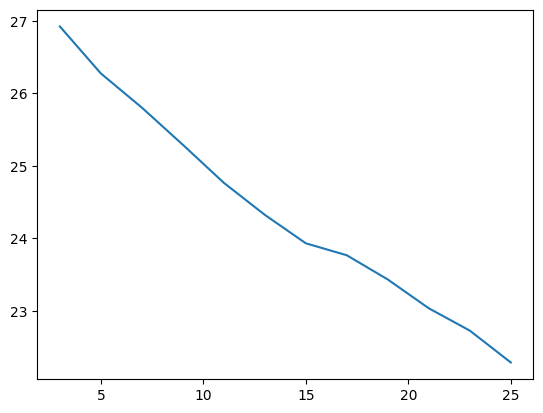

In [7]:
def train_k_means(X,k_value,kmeans):
    model = kmeans(k_value)
    model.fit(X)
    return model

k_values = [i*2+1 for i in range(1,13)]
parameters = [(features,k_value,KMeans) for k_value in k_values]
with mp.Pool(12) as p:
    res = p.starmap(train_k_means,parameters)

plt.plot(k_values,[model.inertia_ for model in res])
groups = res[4].predict(features)
print(groups)

In [8]:
activation_functions = ["tanh"]
beta_values = np.linspace(start=0.01, stop=1, num=17)
learning_rate_values = np.linspace(start=0.01, stop=1, num=17)
num_layers = [1, 2, 3,4]
num_neuron_per_layer = [i+1 for i in range(16)]
hyperparameters = []

for function in activation_functions:
        for learning_rate in learning_rate_values:
            for beta in beta_values:
                for layers in num_layers:
                    for neurons in num_neuron_per_layer:
                        hyperparameters.append({
                            "activation_function": function,
                            "learning_rate": learning_rate,
                            "beta": beta,
                            "num_layers": layers,
                            "num_neuron_per_layer": neurons
                        })

# Verifica los primeros elementos de la lista
print(hyperparameters[1153])
print(len(hyperparameters))


{'activation_function': 'tanh', 'learning_rate': 0.071875, 'beta': 0.071875, 'num_layers': 1, 'num_neuron_per_layer': 2}
18496


In [9]:
def train_model(hyperparameters, k_folds_instances, features, labels, epochs=2000, loss_threshold=1e-5):
    import tensorflow as tf

    num_neurons = hyperparameters["num_neuron_per_layer"]
    num_layers = hyperparameters["num_layers"]
    activation_function = hyperparameters["activation_function"]
    learning_rate = hyperparameters["learning_rate"]
    beta = hyperparameters["beta"]
    
    average_accuracy = 0
    for fold_index, (train_index, test_index) in enumerate(k_folds_instances):
        X_train, X_test = features[train_index], features[test_index]
        Y_train, Y_test = labels[train_index], labels[test_index]
        
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function, input_shape=(features.shape[1],)))
        
        for _ in range(num_layers - 1):
            model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function))
        
        model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Assuming 3 classes
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=beta)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=110, min_delta=loss_threshold, verbose=1)
        history = model.fit(X_train, Y_train, epochs=epochs, verbose=0, callbacks=[callback])
        
        num_epochs_completed = len(history.history['loss'])  # Obtenemos el número de épocas realmente completadas
        final_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]  # Get test accuracy
        average_accuracy += final_accuracy
    
    return [average_accuracy / len(k_folds_instances),num_epochs_completed]


In [10]:
gkf = StratifiedGroupKFold(5)
folds_instances = []
for train_indices, test_indices in gkf.split(features,labels,groups):
    folds_instances.append((train_indices,test_indices))

In [11]:
def nivelation(D, n_p):
    s=len(D)%n_p
    t=int((len(D)-s)/n_p)
    out=[]
    for i in range(n_p):
        if i<s:
            out.append(D[i*t+i:i*t+i+t+1])
        else:
            out.append(D[i*t+s:i*t+s+t])
    return out

def train_models_wrapper(models,k_fold_instances,features,labels,file_path,lock,train_model):
    for model in models:
        with open(file_path,"a") as f:
            results =train_model(model,k_fold_instances,features,labels)
            lock.acquire()
            f.write(f"{model}\t{results[0]}\t{results[1]}\n")
            lock.release()

with mp.Manager() as manager:
    lock = manager.Lock()
    file_path = "models.out"
    open(file_path,"w")
    n_cpu = mp.cpu_count()
    data_listed = nivelation(hyperparameters,n_cpu)
    parameters =[(data,folds_instances,features,labels,file_path,lock,train_model) for data in data_listed
    ]
    with mp.Pool(n_cpu) as p:
        p.starmap(train_models_wrapper,parameters)